# Equations of motion for control moment gyroscope

This notebook makes use of [SymPy](https://docs.sympy.org/), which is a Python library for symbolic mathematics.

In [1]:
import sympy as sym

The `sympy.physics.mechanics` module makes it easier to work with (and display) time derivatives.

In [2]:
from sympy.physics import mechanics
mechanics.init_vprinting()

Define physical constants - in this case, all of the principal moments of inertia (these are the same as in the URDF file that describes the CMG). Also, define moment of inertia matrices in terms of these principal moments. These moment of inertia matrices are described with respect to body-fixed reference frames.

In [3]:
# Principal moments of inertia (matching the URDF)
J1x = sym.nsimplify(0.25)
J1y = J1x
J1z = sym.nsimplify(0.5)
J2x = sym.nsimplify(0.001)
J2y = J2x
J2z = J2x
J3x = sym.nsimplify(0.01)
J3y = J3x
J3z = J3x

# Moment of inertia matrices in body-fixed reference frames
J1 = sym.Matrix.diag(J1x, J1y, J1z)
J2 = sym.Matrix.diag(J2x, J2y, J2z)
J3 = sym.Matrix.diag(J3x, J3y, J3z)

Define variables.

In [4]:
# Time
t = sym.Symbol('t')

# Joint angles:
#
#  q1 is the angle of the "outer" link
#  q2 is the angle of the "inner" link
#  q3 is the angle of the wheel
#
q1, q2, q3 = mechanics.dynamicsymbols('q1, q2, q3')

# Joint velocities
v1 = q1.diff(t)
v2 = q2.diff(t)
v3 = q3.diff(t)

# Joint accelerations
a1 = v1.diff(t)
a2 = v2.diff(t)
a3 = v3.diff(t)

# Torques:
#
#  tau2 is the torque applied by the outer link to the inner link
#  tau3 is the torque applied by the inner link to the wheel
#
tau2, tau3 = sym.symbols('tau2, tau3')

Compute angular velocity of each link with respect to body-fixed reference frames (the choice of frame is very important - using a space-fixed reference frame is a common mistake).

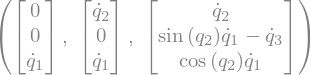

In [5]:
c1 = sym.cos(q1)
s1 = sym.sin(q1)
R_o_in_w = sym.Matrix([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])

c2 = sym.cos(q2)
s2 = sym.sin(q2)
R_i_in_o = sym.Matrix([[1, 0, 0], [0, c2, -s2], [0, s2, c2]])

w1 = sym.Matrix([[0], [0], [v1]])
w2 = R_o_in_w.T * w1 + sym.Matrix([[v2], [0], [0]])
w3 = R_i_in_o.T * w2 + sym.Matrix([[0], [-v3], [0]])

# Show result
w1, w2, w3

Compute Lagrangian.

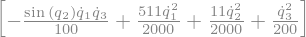

In [6]:
T = sym.simplify(((w1.T * J1 * w1) + (w2.T * J2 * w2) + (w3.T * J3 * w3)) / 2)
V = sym.Matrix([[0]])
L = T - V

# Show result
L

Compute equations of motion.

In [7]:
EOM = L.jacobian([v1, v2, v3]).diff(t) - L.jacobian([q1, q2, q3]) - sym.Matrix([0, tau2, tau3]).T

Simplify equations of motion by solving for accelerations.

In [8]:
sol = sym.solve(EOM, [v1.diff(t), v2.diff(t), v3.diff(t)])
h = sym.together(sym.simplify(sym.Matrix([[sol[a1]], [sol[a2]], [sol[a3]]]), full=True))

Display the vector-valued function $h$ for which the equations of motion can be written as

$$\begin{bmatrix} \ddot{q}_1 \\ \ddot{q}_2 \\ \ddot{q}_3 \end{bmatrix} = h(q_1, q_2, q_3, v_1, v_2, v_3, t_2, t_3)$$

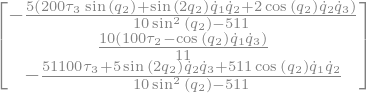

In [9]:
h

Display $h$ as latex-formatted text that could be copy/pasted into a $\LaTeX$ document (or into markdown).

In [10]:
print(f'{mechanics.mlatex(h)}')

\left[\begin{matrix}- \frac{5 \left(200 \tau_{3} \sin{\left(q_{2} \right)} + \sin{\left(2 q_{2} \right)} \dot{q}_{1} \dot{q}_{2} + 2 \cos{\left(q_{2} \right)} \dot{q}_{2} \dot{q}_{3}\right)}{10 \sin^{2}{\left(q_{2} \right)} - 511}\\\frac{10 \left(100 \tau_{2} - \cos{\left(q_{2} \right)} \dot{q}_{1} \dot{q}_{3}\right)}{11}\\- \frac{51100 \tau_{3} + 5 \sin{\left(2 q_{2} \right)} \dot{q}_{2} \dot{q}_{3} + 511 \cos{\left(q_{2} \right)} \dot{q}_{1} \dot{q}_{2}}{10 \sin^{2}{\left(q_{2} \right)} - 511}\end{matrix}\right]
